In [ ]:
! pip -q install equinox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 3.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.8.0 which is incompatible.


In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sympy as sp
import equinox as eqx
from jax.nn import gelu
from scipy.special import roots_legendre

import itertools
import time
import optax

from jax.lax import scan
from jax import random, jit, vmap, grad

%config InlineBackend.figure_format='retina'

# Problem with exact solution

In [ ]:
def np_random_sin(x, amplitudes, k = 2):
    N_terms = amplitudes.shape[0]
    frequencies = sorted([*itertools.product(range(1, N_terms+1), repeat=2)], key=lambda x: sum(x))[:N_terms]
    a = 0
    for n, (i, j) in enumerate(frequencies):
        a += amplitudes[n]*sp.sin(sp.pi*i*x[0])*sp.sin(sp.pi*j*x[1]) / (1 + (sp.pi*i)**2 + (sp.pi*j)**2)**k
    return a

In [ ]:
key = random.PRNGKey(44)
N_terms = 10
amplitudes = random.normal(key, (N_terms,))

x, y = sp.Symbol("x"), sp.Symbol("y")

a_ = np_random_sin([x, y], amplitudes, k = 1)
A_ = sp.lambdify([x, y], a_, 'jax')
A = lambda x: A_(x[0], x[1])

N_mesh = 200
x_ = jnp.linspace(0, 1, N_mesh)
coords = jnp.stack(jnp.meshgrid(x_, x_), 2)
val_A = A(coords.T)
min_a, max_a = jnp.min(val_A).item(), jnp.max(val_A).item()

a = (5 * (a_ - min_a) / (max_a - min_a) + 1)

In [ ]:
phi = x*(1-x)*y*(1-y)
f = - (a * phi.diff("x")).diff("x") - (a * phi.diff("y")).diff("y")
J = (phi.diff("x")**2 + phi.diff("y"))*a/2 - phi*f

rhs_ = sp.lambdify([x, y], f, 'jax')
a_ = sp.lambdify([x, y], a, 'jax')
sol_ = sp.lambdify([x, y], phi, 'jax')
J_ = sp.lambdify([x, y], J, 'jax')
dx_sol_ = sp.lambdify([x, y], phi.diff('x'), 'jax')
dy_sol_ = sp.lambdify([x, y], phi.diff('y'), 'jax')

rhs = lambda x: rhs_(x[0], x[1])
a = lambda x: a_(x[0], x[1])
sol = lambda x: sol_(x[0], x[1])
dx_sol = lambda x: dx_sol_(x[0], x[1])
dy_sol = lambda x: dy_sol_(x[0], x[1])
J = lambda x: J_(x[0], x[1])

In [ ]:
N_mesh = 200
x, weights = roots_legendre(N_mesh)
x = jnp.array((x + 1)/2)
weights = jnp.array(weights).reshape(1, -1)
coords = jnp.stack(jnp.meshgrid(x, x), 2)
coords = coords.reshape(-1, 2)

J_val = jnp.sum(jnp.sum(J(coords.T).reshape(N_mesh, N_mesh)*weights, 1)*weights[0])

N_mesh = 200
x = jnp.linspace(0, 1, N_mesh)
coords = jnp.stack(jnp.meshgrid(x, x), 2)
C_F = 1 / (jnp.sqrt(jnp.min(a(coords.T)))*jnp.pi*2)

In [ ]:
coords.shape

(200, 200, 2)

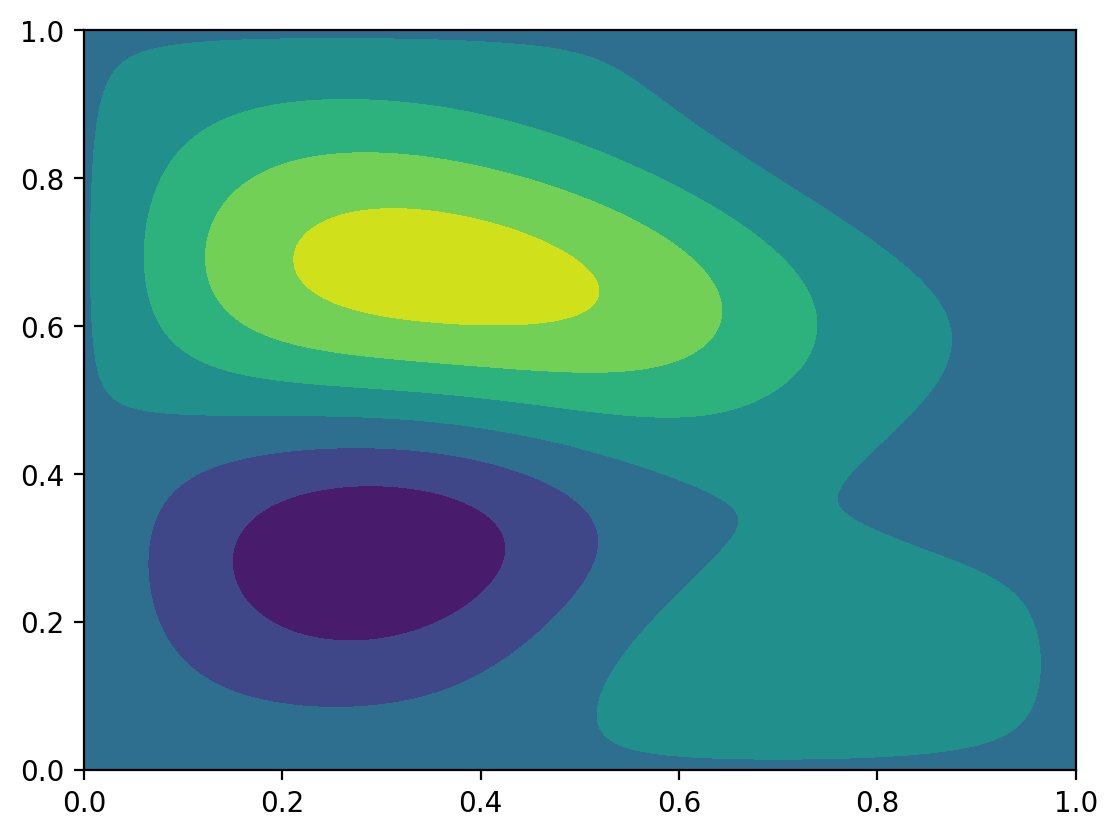

In [ ]:
a_val = a(coords.T)

plt.contourf(coords[:, :, 0], coords[:, :, 1], a_val)

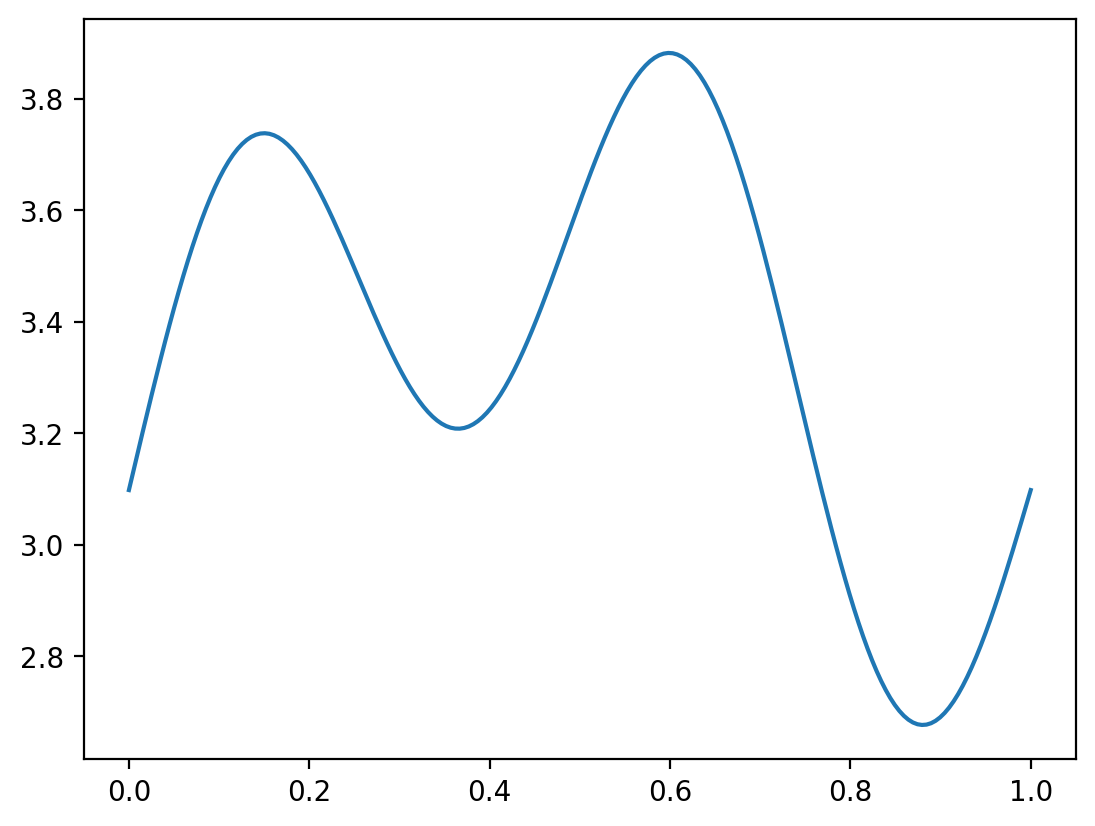

In [ ]:
plt.plot(coords[:, 150, 1], a_val[:, 150])

# Residual loss

In [ ]:
class PiNN(eqx.Module):
    matrices: list
    biases: list

    def __init__(self, N_features, N_layers, key):
        keys = random.split(key, N_layers+1)
        features = [N_features[0],] + [N_features[1],]*(N_layers-1) + [N_features[-1],]
        self.matrices = [random.normal(key, (f_in, f_out)) / jnp.sqrt((f_in + f_out)/2) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]
        keys = random.split(keys[-1], N_layers)
        self.biases = [random.normal(key, (f_out,)) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]

    def __call__(self, x, B):
        f = jnp.concatenate([jnp.cos(B @ x), jnp.sin(B @ x)], 0)
        f = f @ self.matrices[0] + self.biases[0]
        for i in range(1, len(self.matrices)):
            f = gelu(f)
            f = f @ self.matrices[i] + self.biases[i]
        return jnp.sin(jnp.pi*x[0]) * jnp.sin(jnp.pi*x[1]) * f[0]

def compute_loss(model, coordinates, B):
    def l(x):
        flux_x = lambda x: a(x)*grad(model, argnums=0)(x, B)[0]
        flux_y = lambda x: a(x)*grad(model, argnums=0)(x, B)[1]
        return grad(flux_x)(x)[0] + grad(flux_y)(x)[1]
    return jnp.linalg.norm(vmap(l)(coordinates) + rhs(coordinates.T))

def compute_error_energy_norm(model, coordinates, weights, B):
    def l(x):
        flux = grad(model, argnums=0)(x, B)
        return a(x)*((flux[0] - dx_sol(x))**2 + (flux[1] - dy_sol(x))**2)
    integrand = vmap(l)(coordinates)
    l = jnp.sum(jnp.sum(integrand.reshape(weights.size, weights.size)*weights, axis=1) * weights[0]) / 4
    return l

def compute_spectral_loss(model, coordinates, weights, B):
    def l(x):
        flux_x = lambda x: a(x)*grad(model, argnums=0)(x, B)[0]
        flux_y = lambda x: a(x)*grad(model, argnums=0)(x, B)[1]
        return grad(flux_x)(x)[0] + grad(flux_y)(x)[1]

    integrand = (vmap(l)(coordinates) + rhs(coordinates.T))**2
    integral = jnp.sum(jnp.sum(integrand.reshape(weights.size, weights.size)*weights, axis=1) * weights[0]) / 4
    return integral

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

@eqx.filter_jit
def make_step(model, coordinates, B, optim, opt_state):
    loss, grads = compute_loss_and_grads(model, coordinates, B)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [ ]:
N_mesh = 64
N_epochs = 50000
M = 16*16
coords = jnp.linspace(0, 1, N_mesh)
coords = jnp.stack(jnp.meshgrid(coords, coords), 2)
coords = coords.reshape(-1, 2)
N_fourier_features = 25
key = random.PRNGKey(23)
B = random.normal(key, (N_fourier_features, 2))*10

x_, weights_ = roots_legendre(N_mesh)
x_ = jnp.array((x_ + 1)/2)
weights_ = jnp.array(weights_).reshape(1, -1)
coords_ = jnp.stack(jnp.meshgrid(x_, x_), 2)
coords_ = coords_.reshape(-1, 2)

N_features = [2*N_fourier_features, 50, 1]
N_layers = 3
key = random.PRNGKey(14)
model = PiNN(N_features, N_layers, key)

learning_rate = 1e-4
N_drop = 10000
gamma = 0.5
sc = optax.exponential_decay(learning_rate, N_drop, gamma)
optim = optax.lion(learning_rate=sc)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

carry = [model, opt_state, sol(coords.T), coords, B, coords_, weights_]
keys = random.split(key, N_epochs)

In [ ]:
def make_step_scan(carry, key):
    model, opt_state, exact_solution, coords, B, coords_, weights_ = carry
    x = random.choice(key, coords, shape = (M,))
    loss, model, opt_state = make_step(model, x, B, optim, opt_state)
    approximate_solution = vmap(model, in_axes=(0, None))(coords, B)
    error_ = jnp.sqrt(compute_error_energy_norm(model, coords_, weights_, B))#jnp.linalg.norm(exact_solution - approximate_solution)
    return [model, opt_state, exact_solution, coords, B, coords_, weights_], jnp.stack([loss, error_])

In [ ]:
start = time.time()
data, history = scan(make_step_scan, carry, keys)
model = data[0]
stop = time.time()
print((stop - start)/60)

0.5892203013102214


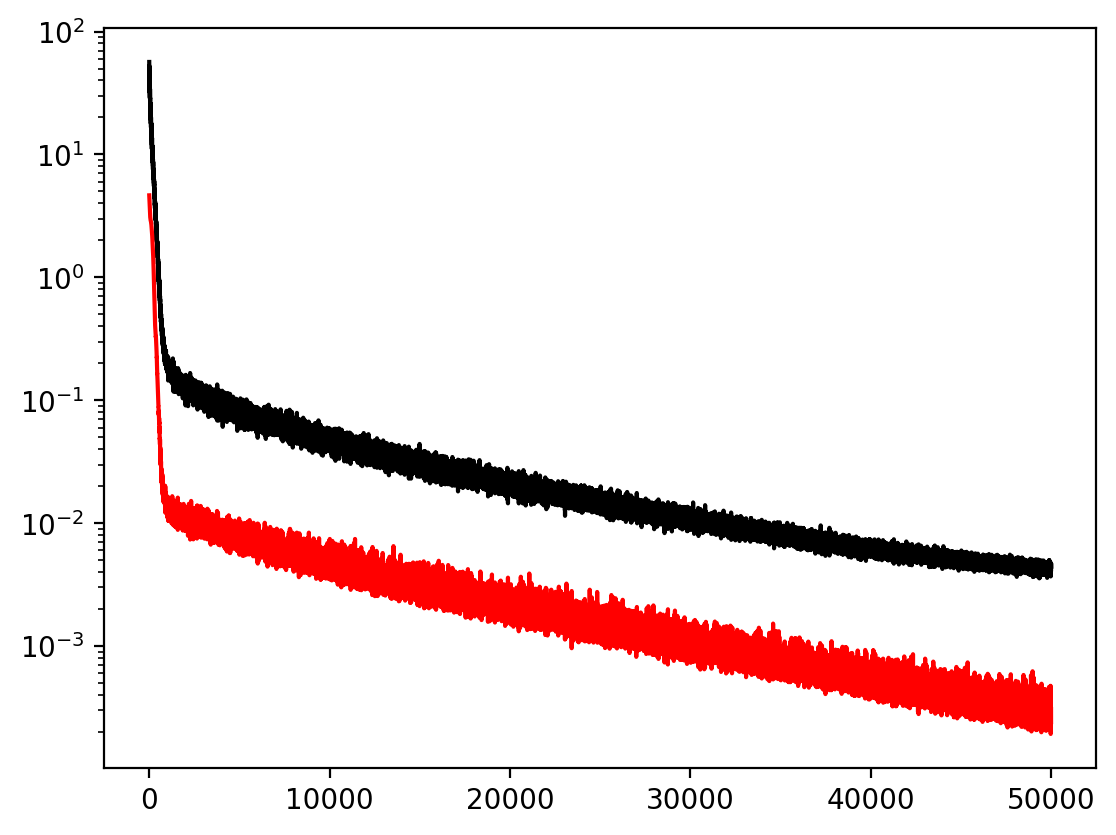

In [ ]:
plt.yscale("log")
plt.plot(history[:, 0] / N_mesh, color="black", label="square root of energy norm")
plt.plot(history[:, 1], color="red", label="$L_{2}$ error");

In [ ]:
approximate_solution = vmap(model, in_axes=(0, None))(coords, B)
exact_solution = sol(coords.T)
rel_error = jnp.linalg.norm(exact_solution - approximate_solution) / jnp.linalg.norm(approximate_solution)
rel_error

Array(0.00023068, dtype=float32)

In [ ]:
N_mesh = 200
x_, weights_ = roots_legendre(N_mesh)
x_ = jnp.array((x_ + 1)/2)
weights_ = jnp.array(weights_).reshape(1, -1)
coords_ = jnp.stack(jnp.meshgrid(x_, x_), 2)
coords_ = coords_.reshape(-1, 2)

energy_norm = jnp.sqrt(compute_error_energy_norm(model, coords_, weights_, B))
energy_norm

Array(0.00024087, dtype=float32)

In [ ]:
jnp.sqrt(compute_spectral_loss(model, coords_, weights_, B))

Array(0.01709353, dtype=float32)

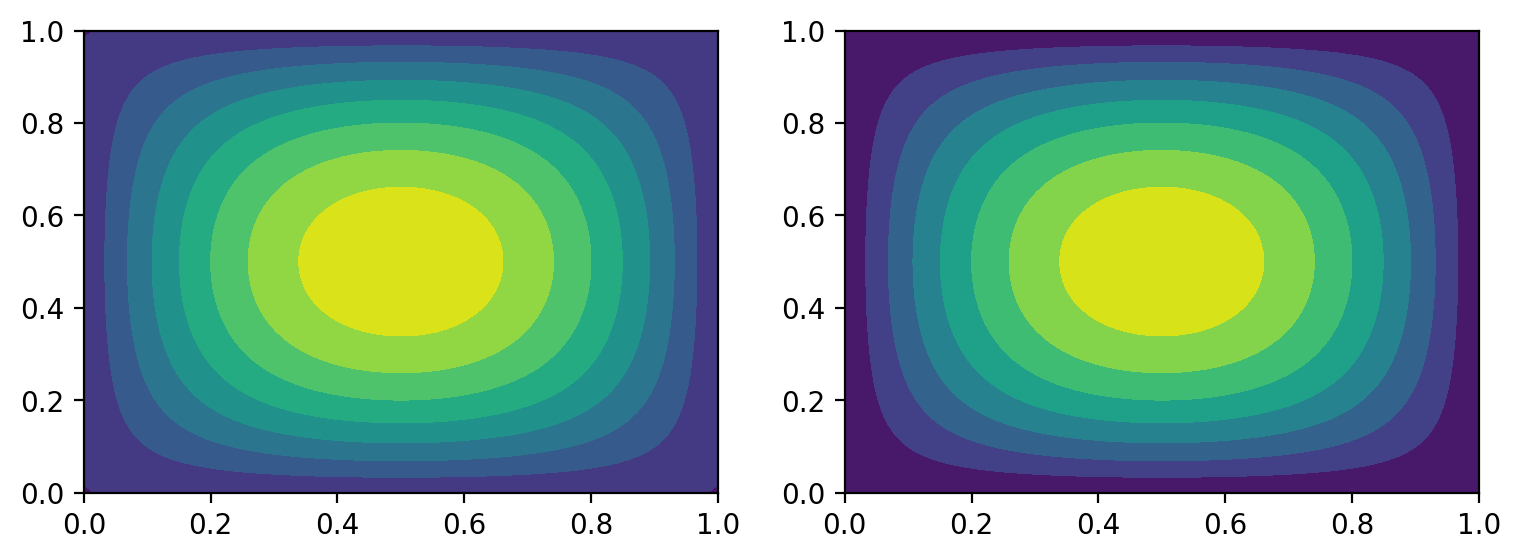

In [ ]:
N_mesh = 64
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax[0].contourf(coords[:, 0].reshape(N_mesh, N_mesh), coords[:, 1].reshape(N_mesh, N_mesh), approximate_solution.reshape(N_mesh, N_mesh))
ax[1].contourf(coords[:, 0].reshape(N_mesh, N_mesh), coords[:, 1].reshape(N_mesh, N_mesh), exact_solution.reshape(N_mesh, N_mesh));

# Deep Ritz, Gauss quadrature

In [ ]:
class PiNN(eqx.Module):
    matrices: list
    biases: list

    def __init__(self, N_features, N_layers, key):
        keys = random.split(key, N_layers+1)
        features = [N_features[0],] + [N_features[1],]*(N_layers-1) + [N_features[-1],]
        self.matrices = [random.normal(key, (f_in, f_out)) / jnp.sqrt((f_in + f_out)/2) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]
        keys = random.split(keys[-1], N_layers)
        self.biases = [random.normal(key, (f_out,)) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]

    def __call__(self, x, B):
        f = jnp.concatenate([jnp.cos(B @ x), jnp.sin(B @ x)], 0)
        f = f @ self.matrices[0] + self.biases[0]
        for i in range(1, len(self.matrices)):
            f = gelu(f)
            f = f @ self.matrices[i] + self.biases[i]
        return jnp.sin(jnp.pi*x[0]) * jnp.sin(jnp.pi*x[1]) * f[0]

def compute_loss(model, coordinates, weights, RHS, A, B):
    def get_data(x):
        flux = grad(model, argnums=0)(x, B)
        w = model(x, B)
        return flux, w
    flux, w = vmap(get_data)(coordinates)
    integrand = A*(flux[:, 0]**2 + flux[:, 1]**2)/2 - RHS*w
    l = jnp.sum(jnp.sum(integrand.reshape(weights.size, weights.size)*weights, axis=1) * weights[0]) / 4
    return l

def compute_error_energy_norm(model, coordinates, weights, B):
    def l(x):
        flux = grad(model, argnums=0)(x, B)
        return a(x)*((flux[0] - dx_sol(x))**2 + (flux[1] - dy_sol(x))**2)
    integrand = vmap(l)(coordinates)
    l = jnp.sum(jnp.sum(integrand.reshape(weights.size, weights.size)*weights, axis=1) * weights[0]) / 4
    return l

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

@eqx.filter_jit
def make_step(model, coordinates, weights, RHS, A, B, optim, opt_state):
    loss, grads = compute_loss_and_grads(model, coordinates, weights, RHS, A, B)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [ ]:
N_mesh = 64
N_epochs = 50000
M = 16*16

x, weights = roots_legendre(N_mesh)
x = jnp.array((x + 1)/2)
weights = jnp.array(weights).reshape(1, -1)
coords = jnp.stack(jnp.meshgrid(x, x), 2)
coords = coords.reshape(-1, 2)
N_fourier_features = 25
key = random.PRNGKey(23)
B = random.normal(key, (N_fourier_features, 2))*10

N_features = [2*N_fourier_features, 50, 1]
N_layers = 3
key = random.PRNGKey(14)
model = PiNN(N_features, N_layers, key)

learning_rate = 1e-4
N_drop = 10000
gamma = 0.5
sc = optax.exponential_decay(learning_rate, N_drop, gamma)
optim = optax.lion(learning_rate=sc)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

carry = [model, opt_state, coords, weights, rhs(coords.T), a(coords.T), B, sol(coords.T)]
keys = random.split(key, N_epochs)

In [ ]:
def make_step_scan(carry, key):
    model, opt_state, coordinates, weights, RHS, A, B, exact_solution = carry
    loss, model, opt_state = make_step(model, coordinates, weights, RHS, A, B, optim, opt_state)
    approximate_solution = vmap(model, in_axes=(0, None))(coordinates, B)
    error_ = jnp.sqrt(compute_error_energy_norm(model, coordinates, weights, B))
    #error_ = jnp.sum(jnp.sum(((exact_solution - approximate_solution)**2).reshape(weights.size, weights.size)*weights, axis=1)*weights[0])
    return [model, opt_state, coordinates, weights, RHS, A, B, exact_solution], jnp.stack([loss, jnp.sqrt(error_)])

In [ ]:
start = time.time()
data, history = scan(make_step_scan, carry, keys)
model = data[0]
stop = time.time()
print((stop - start)/60)

0.964852492014567


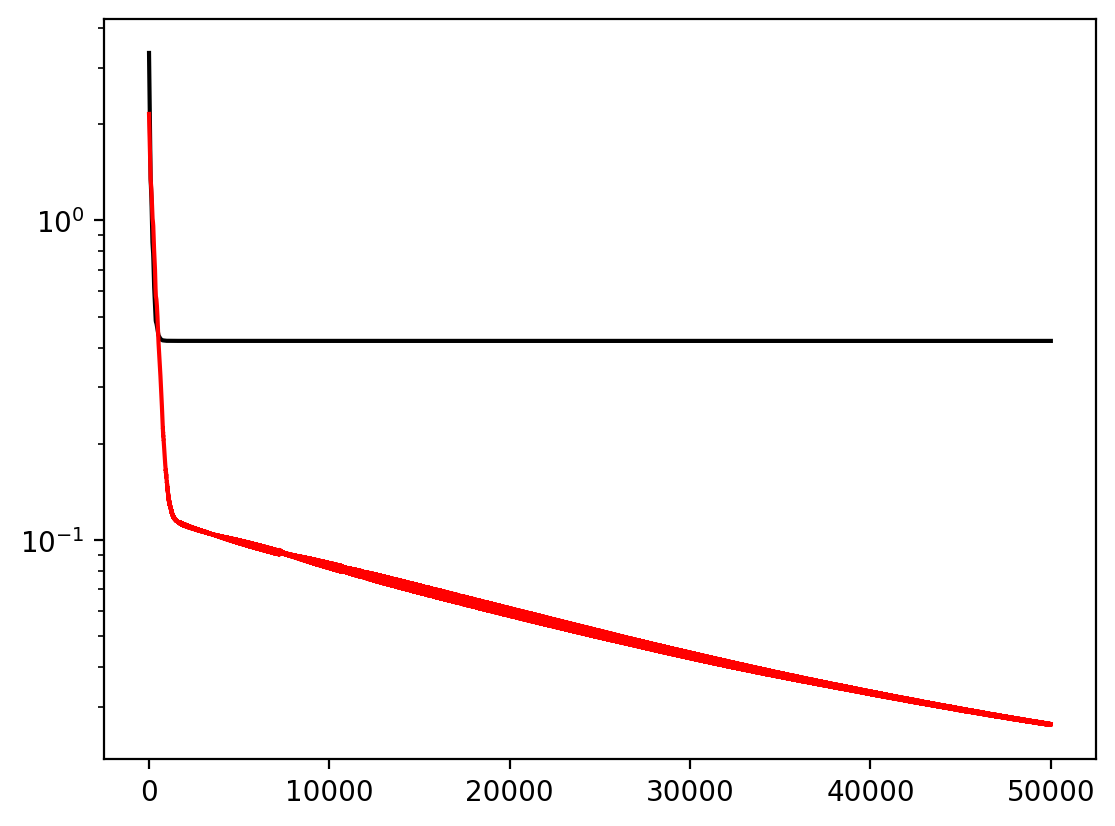

In [ ]:
plt.yscale("log")
plt.plot(jnp.sqrt(history[:, 0] - J_val), color="black", label="residual")
plt.plot(history[:, 1], color="red", label="$L_{2}$ error");

In [ ]:
approximate_solution = vmap(model, in_axes=(0, None))(coords, B)
exact_solution = sol(coords.T)
rel_error = jnp.sqrt(jnp.sum(jnp.sum(((exact_solution - approximate_solution)**2).reshape(weights.size, weights.size)*weights, axis=1)*weights[0])) / jnp.sqrt(jnp.sum(jnp.sum(((exact_solution)**2).reshape(weights.size, weights.size)*weights, axis=1)*weights[0]))
rel_error

Array(0.00158068, dtype=float32)

In [ ]:
energy_norm = jnp.sqrt(compute_error_energy_norm(model, coords, weights, B))
energy_norm

Array(0.00070432, dtype=float32)

In [ ]:
N_mesh = 200
x_, weights_ = roots_legendre(N_mesh)
x_ = jnp.array((x_ + 1)/2)
weights_ = jnp.array(weights_).reshape(1, -1)
coords_ = jnp.stack(jnp.meshgrid(x_, x_), 2)
coords_ = coords_.reshape(-1, 2)

energy_norm = jnp.sqrt(compute_error_energy_norm(model, coords_, weights_, B))
energy_norm

Array(0.0007045, dtype=float32)

In [ ]:
RHS, A = rhs(coords_.T), a(coords_.T)
compute_loss(model, coords_, weights_, RHS, A, B)

Array(-0.03645018, dtype=float32)

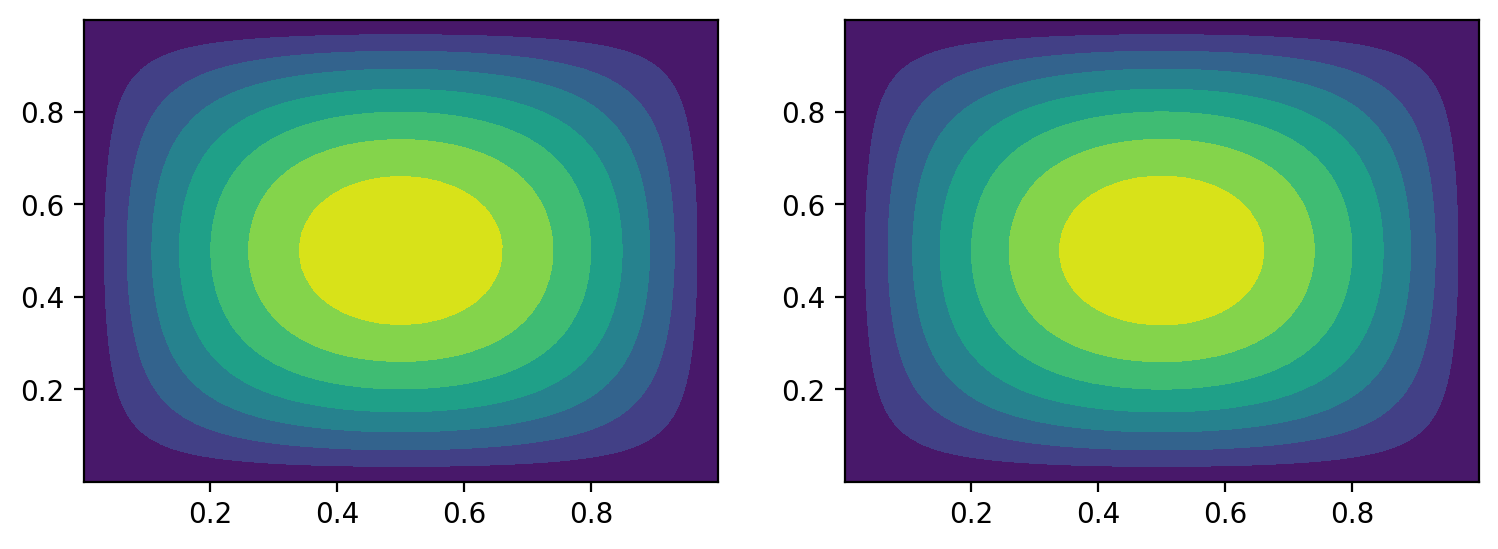

In [ ]:
N_mesh = 64
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax[0].contourf(coords[:, 0].reshape(N_mesh, N_mesh), coords[:, 1].reshape(N_mesh, N_mesh), approximate_solution.reshape(N_mesh, N_mesh))
ax[1].contourf(coords[:, 0].reshape(N_mesh, N_mesh), coords[:, 1].reshape(N_mesh, N_mesh), exact_solution.reshape(N_mesh, N_mesh));

# Deep Ritz, Monte Carlo

In [ ]:
class PiNN(eqx.Module):
    matrices: list
    biases: list

    def __init__(self, N_features, N_layers, key):
        keys = random.split(key, N_layers+1)
        features = [N_features[0],] + [N_features[1],]*(N_layers-1) + [N_features[-1],]
        self.matrices = [random.normal(key, (f_in, f_out)) / jnp.sqrt((f_in + f_out)/2) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]
        keys = random.split(keys[-1], N_layers)
        self.biases = [random.normal(key, (f_out,)) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]

    def __call__(self, x, B):
        f = jnp.concatenate([jnp.cos(B @ x), jnp.sin(B @ x)], 0)
        f = f @ self.matrices[0] + self.biases[0]
        for i in range(1, len(self.matrices)):
            f = gelu(f)
            f = f @ self.matrices[i] + self.biases[i]
        return jnp.sin(jnp.pi*x[0]) * jnp.sin(jnp.pi*x[1]) * f[0]

def compute_loss(model, coordinates, B):
    def get_data(x):
        flux = grad(model, argnums=0)(x, B)
        w = model(x, B)
        return flux, w
    flux, w = vmap(get_data)(coordinates)
    integrand = a(coordinates.T)*(flux[:, 0]**2 + flux[:, 1]**2)/2 - rhs(coordinates.T)*w
    l = jnp.mean(integrand)
    return l

def compute_spectral_loss(model, coordinates, weights, B):
    def get_data(x):
        flux = grad(model, argnums=0)(x, B)
        w = model(x, B)
        return flux, w

    flux, w = vmap(get_data)(coordinates)
    integrand = a(coordinates.T)*(flux[:, 0]**2 + flux[:, 1]**2)/2 - rhs(coordinates.T)*w
    integral = jnp.sum(jnp.sum(integrand.reshape(weights.size, weights.size)*weights, axis=1) * weights[0]) / 4
    return integral

def compute_error_energy_norm(model, coordinates, weights, B):
    def l(x):
        flux = grad(model, argnums=0)(x, B)
        return a(x)*((flux[0] - dx_sol(x))**2 + (flux[1] - dy_sol(x))**2)
    integrand = vmap(l)(coordinates)
    l = jnp.sum(jnp.sum(integrand.reshape(weights.size, weights.size)*weights, axis=1) * weights[0]) / 4
    return l

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

@eqx.filter_jit
def make_step(model, coordinates, B, optim, opt_state):
    loss, grads = compute_loss_and_grads(model, coordinates, B)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [ ]:
N_mesh = 64
N_epochs = 50000
M = 25*25

coords = jnp.linspace(0, 1, N_mesh)
coords = jnp.stack(jnp.meshgrid(coords, coords), 2)
coords = coords.reshape(-1, 2)
N_fourier_features = 25
key = random.PRNGKey(23)
B = random.normal(key, (N_fourier_features, 2))*10

x_, weights_ = roots_legendre(N_mesh)
x_ = jnp.array((x_ + 1)/2)
weights_ = jnp.array(weights_).reshape(1, -1)
coords_ = jnp.stack(jnp.meshgrid(x_, x_), 2)
coords_ = coords_.reshape(-1, 2)

N_features = [2*N_fourier_features, 50, 1]
N_layers = 3
key = random.PRNGKey(14)
model = PiNN(N_features, N_layers, key)

learning_rate = 1e-4
N_drop = 10000
gamma = 0.5
sc = optax.exponential_decay(learning_rate, N_drop, gamma)
optim = optax.lion(learning_rate=sc)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

carry = [model, opt_state, coords, B, sol(coords.T), key, coords_, weights_]
keys = random.split(key, N_epochs)

In [ ]:
def make_step_scan(carry, key):
    model, opt_state, coordinates, B, exact_solution, key, coords_, weights_ = carry
    key = random.split(key)[1]
    coords = random.uniform(key, (M, 2))
    loss, model, opt_state = make_step(model, coords, B, optim, opt_state)
    approximate_solution = vmap(model, in_axes=(0, None))(coordinates, B)
    error_ = jnp.sqrt(compute_error_energy_norm(model, coords_, weights_, B))
    #error_ = jnp.linalg.norm(exact_solution - approximate_solution)
    return [model, opt_state, coordinates, B, exact_solution, key, coords_, weights_], jnp.stack([loss, error_])

In [ ]:
start = time.time()
data, history = scan(make_step_scan, carry, keys)
model = data[0]
stop = time.time()
print((stop - start)/60)

0.4695887525876363


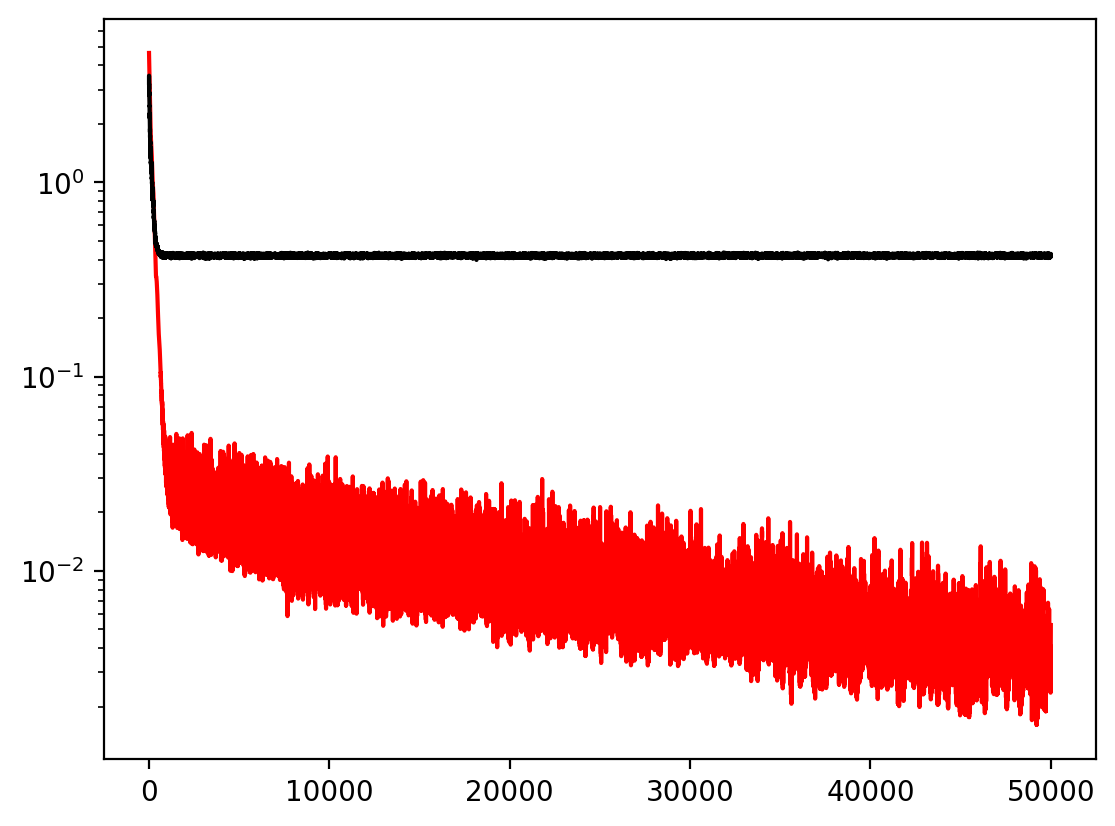

In [ ]:
plt.yscale("log")
plt.plot(history[:, 1], color="red", label="$L_{2}$ error")
plt.plot(jnp.sqrt(history[:, 0] - J_val), color="black", label="residual");

In [ ]:
approximate_solution = vmap(model, in_axes=(0, None))(coords, B)
exact_solution = sol(coords.T)
rel_error = jnp.linalg.norm(exact_solution - approximate_solution) / jnp.linalg.norm(exact_solution)
rel_error

Array(0.01777897, dtype=float32)

In [ ]:
energy_norm = jnp.sqrt(compute_error_energy_norm(model, coords_, weights_, B))
energy_norm

Array(0.0052527, dtype=float32)

In [ ]:
N_mesh = 200
x_, weights_ = roots_legendre(N_mesh)
x_ = jnp.array((x_ + 1)/2)
weights_ = jnp.array(weights_).reshape(1, -1)
coords_ = jnp.stack(jnp.meshgrid(x_, x_), 2)
coords_ = coords_.reshape(-1, 2)

energy_norm = jnp.sqrt(compute_error_energy_norm(model, coords_, weights_, B))
energy_norm

Array(0.0052527, dtype=float32)

In [ ]:
compute_spectral_loss(model, coords_, weights_, B)

Array(-0.03643664, dtype=float32)

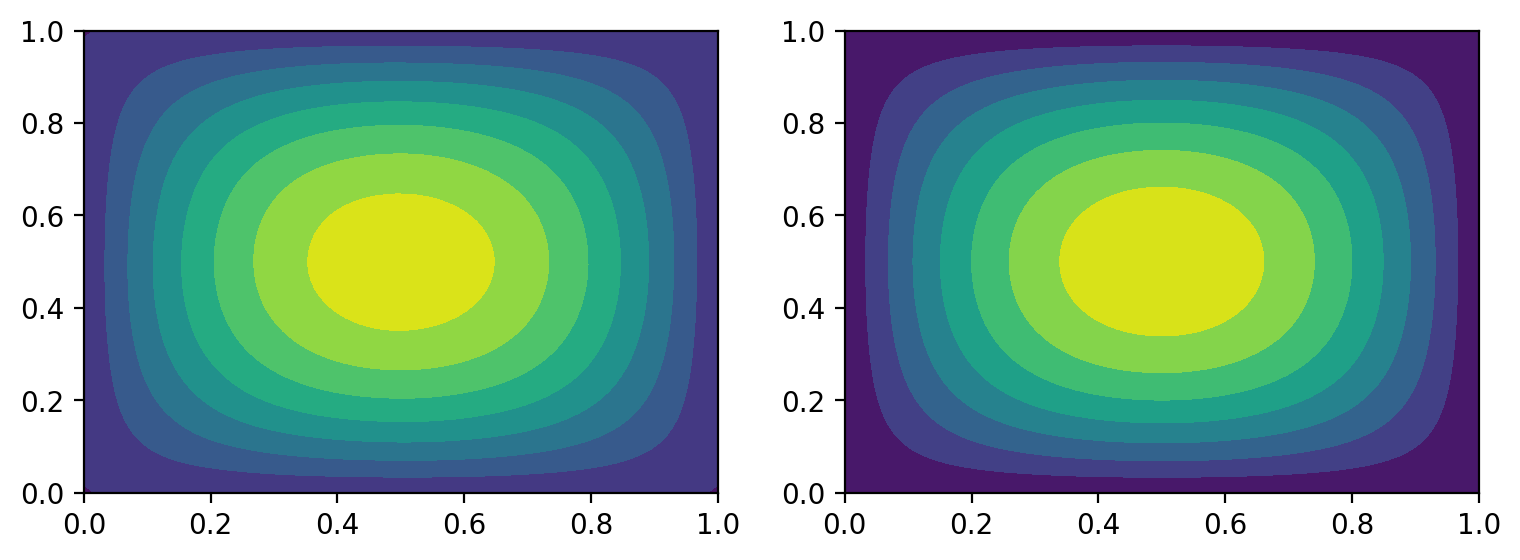

In [ ]:
N_mesh = 64

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax[0].contourf(coords[:, 0].reshape(N_mesh, N_mesh), coords[:, 1].reshape(N_mesh, N_mesh), approximate_solution.reshape(N_mesh, N_mesh))
ax[1].contourf(coords[:, 0].reshape(N_mesh, N_mesh), coords[:, 1].reshape(N_mesh, N_mesh), exact_solution.reshape(N_mesh, N_mesh));

# Functional error estimate

In [ ]:
class PiNNu(eqx.Module):
    matrices: list
    biases: list

    def __init__(self, N_features, N_layers, key):
        keys = random.split(key, N_layers+1)
        features = [N_features[0],] + [N_features[1],]*(N_layers-1) + [N_features[-1],]
        self.matrices = [random.normal(key, (f_in, f_out)) / jnp.sqrt((f_in + f_out)/2) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]
        keys = random.split(keys[-1], N_layers)
        self.biases = [random.normal(key, (f_out,)) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]

    def __call__(self, x, B):
        f = jnp.concatenate([jnp.cos(B @ x), jnp.sin(B @ x)], 0)
        f = f @ self.matrices[0] + self.biases[0]
        for i in range(1, len(self.matrices)):
            f = gelu(f)
            f = f @ self.matrices[i] + self.biases[i]
        return f[0]

class PiNN3(eqx.Module):
    models: list
    beta: jnp.array

    def __init__(self, N_features, N_layers, key):
        keys = random.split(key, 3)
        self.models = [PiNNu(N_features, N_layers, key) for key in keys[:2]]
        self.models.append(PiNN(N_features, N_layers, keys[-1]))
        self.beta = jnp.array([1.0,])

    def __call__(self, x, B, i):
        return self.models[i](x, B)

def compute_loss(model, coordinates, weights, RHS, A, B, C_F):
    flux = vmap(grad(lambda x, B: model(x, B, 2), argnums=0), in_axes=(0, None))(coordinates, B)
    dx_y = [vmap(grad(lambda x, B: model(x, B, i), argnums=0), in_axes=(0, None))(coordinates, B)[:, i] for i in [0, 1]]
    y1 = vmap(model, in_axes=(0, None, None))(coordinates, B, 0)
    y2 = vmap(model, in_axes=(0, None, None))(coordinates, B, 1)
    integrand = (1 + model.beta[0]**2)*(C_F**2*(RHS + dx_y[0] + dx_y[1])**2 +  ((A*flux[:, 0] - y1)**2 + (A*flux[:, 1] - y2)**2) / (A*model.beta[0]**2))
    l = jnp.sum(jnp.sum(integrand.reshape(weights.size, weights.size)*weights, axis=1) * weights[0]) / 4
    return l

def compute_error_energy_norm(model, coordinates, weights, B):
    def l(x):
        flux = grad(model, argnums=0)(x, B, 2)
        return a(x)*((flux[0] - dx_sol(x))**2 + (flux[1] - dy_sol(x))**2)
    integrand = vmap(l)(coordinates)
    l = jnp.sum(jnp.sum(integrand.reshape(weights.size, weights.size)*weights, axis=1) * weights[0]) / 4
    return l

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

@eqx.filter_jit
def make_step(model, coordinates, weights, RHS, A, B, C_F, optim, opt_state):
    loss, grads = compute_loss_and_grads(model, coordinates, weights, RHS, A, B, C_F)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [ ]:
N_mesh = 64
N_epochs = 50000
M = 16*16

x, weights = roots_legendre(N_mesh)
x = jnp.array((x + 1)/2)
weights = jnp.array(weights).reshape(1, -1)
coords = jnp.stack(jnp.meshgrid(x, x), 2)
coords = coords.reshape(-1, 2)
N_fourier_features = 25
key = random.PRNGKey(23)
B = random.normal(key, (N_fourier_features, 2))*10

N_features = [2*N_fourier_features, 50, 1]
N_layers = 3
key = random.PRNGKey(14)
model = PiNN3(N_features, N_layers, key)

learning_rate = 1e-4
N_drop = 10000
gamma = 0.5
sc = optax.exponential_decay(learning_rate, N_drop, gamma)
optim = optax.lion(learning_rate=sc)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

carry = [model, opt_state, coords, weights, rhs(coords.T), a(coords.T), B, C_F, sol(coords.T)]
keys = random.split(key, N_epochs)

In [ ]:
def make_step_scan(carry, key):
    model, opt_state, coordinates, weights, RHS, A, B, C_F, exact_solution = carry
    loss, model, opt_state = make_step(model, coordinates, weights, RHS, A, B, C_F, optim, opt_state)
    approximate_solution = vmap(model, in_axes=(0, None, None))(coordinates, B, 2)
    #error_ = jnp.sum(jnp.sum(((exact_solution - approximate_solution)**2).reshape(weights.size, weights.size)*weights, axis=1)*weights[0])
    error_ = compute_error_energy_norm(model, coordinates, weights, B)
    return [model, opt_state, coordinates, weights, RHS, A, B, C_F, exact_solution], jnp.stack([jnp.sqrt(loss), jnp.sqrt(error_)])

In [ ]:
start = time.time()
data, history = scan(make_step_scan, carry, keys)
model = data[0]
stop = time.time()
print((stop - start)/60)

2.2748326460520425


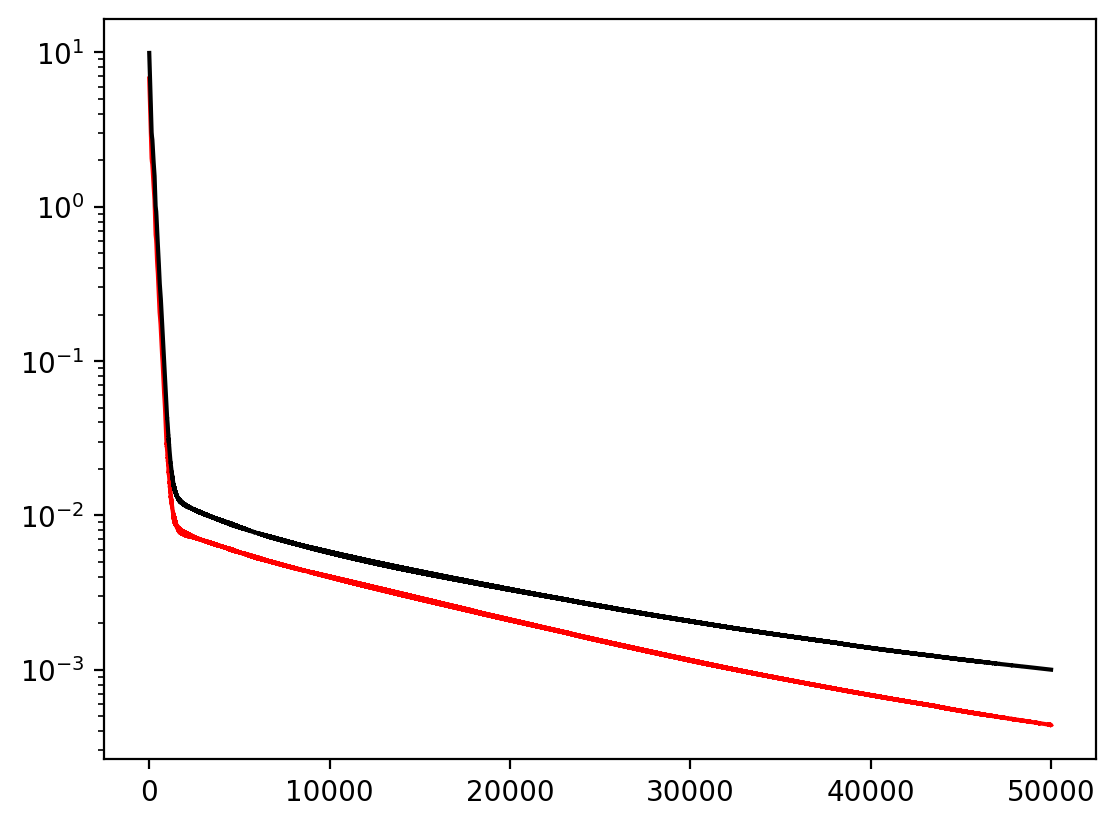

In [ ]:
plt.yscale("log")
plt.plot(history[:, 1], color="red", label="$L_{2}$ error")
plt.plot(history[:, 0], color="black", label="residual");

In [ ]:
approximate_solution = vmap(model, in_axes=(0, None, None))(coords, B, 2)
exact_solution = sol(coords.T)
rel_error = jnp.sqrt(jnp.sum(jnp.sum(((exact_solution - approximate_solution)**2).reshape(weights.size, weights.size)*weights, axis=1)*weights[0])) / jnp.sqrt(jnp.sum(jnp.sum(((exact_solution)**2).reshape(weights.size, weights.size)*weights, axis=1)*weights[0]))
rel_error

Array(0.00088671, dtype=float32)

In [ ]:
energy_norm = jnp.sqrt(compute_error_energy_norm(model, coords, weights, B))
energy_norm

Array(0.00043845, dtype=float32)

In [ ]:
RHS, A = rhs(coords.T), a(coords.T)
loss_ = compute_loss(model, coords, weights, RHS, A, B, C_F)
jnp.sqrt(loss_)

Array(0.00100031, dtype=float32)

In [ ]:
N_mesh = 200
x, weights = roots_legendre(N_mesh)
x = jnp.array((x + 1)/2)
weights = jnp.array(weights).reshape(1, -1)
coords = jnp.stack(jnp.meshgrid(x, x), 2)
coords = coords.reshape(-1, 2)

energy_norm = jnp.sqrt(compute_error_energy_norm(model, coords, weights, B))
energy_norm

Array(0.0004383, dtype=float32)

In [ ]:
RHS, A = rhs(coords.T), a(coords.T)
loss_ = compute_loss(model, coords, weights, RHS, A, B, C_F)
jnp.sqrt(loss_)

Array(0.00100019, dtype=float32)

In [ ]:
N_mesh = 200
x, weights = roots_legendre(N_mesh)
x = jnp.array((x + 1)/2)
weights = jnp.array(weights).reshape(1, -1)
coords = jnp.stack(jnp.meshgrid(x, x), 2)
coords = coords.reshape(-1, 2)

energy_norm = jnp.sqrt(compute_error_energy_norm(model, coords, weights, B))
energy_norm

Array(0.0004383, dtype=float32)

In [ ]:
RHS, A = rhs(coords.T), a(coords.T)
loss_ = compute_loss(model, coords, weights, RHS, A, B, C_F)
jnp.sqrt(loss_)

Array(0.00100019, dtype=float32)

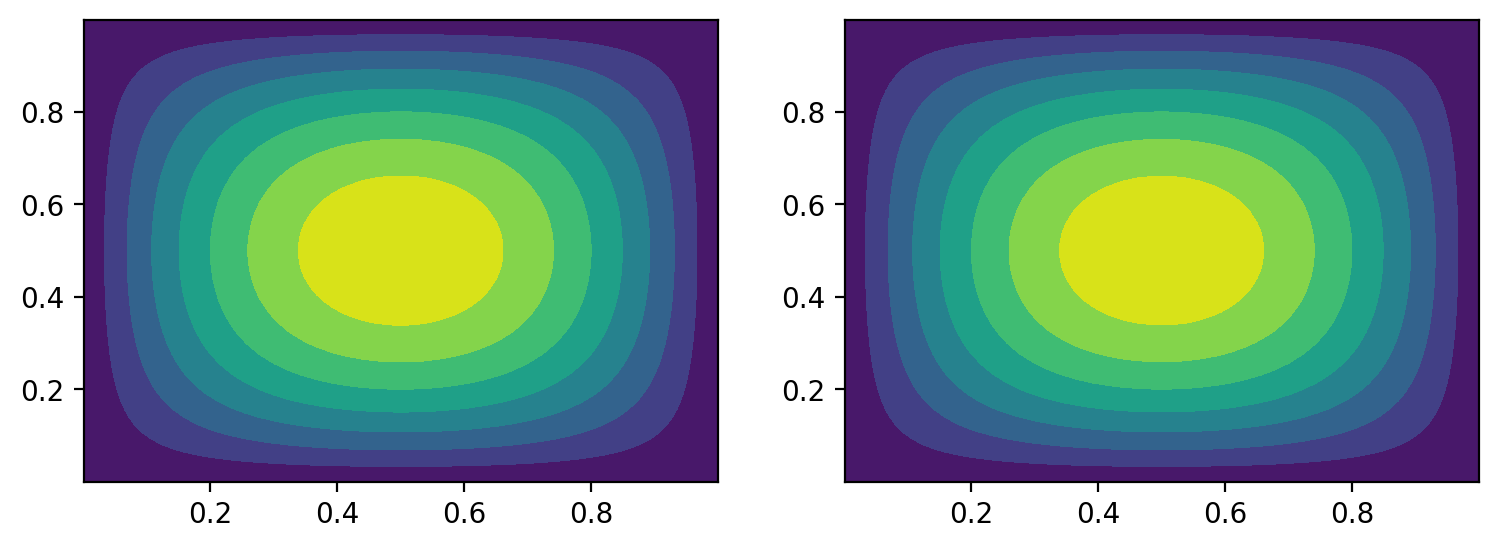

In [ ]:
N_mesh = 64
x, weights = roots_legendre(N_mesh)
x = jnp.array((x + 1)/2)
weights = jnp.array(weights).reshape(1, -1)
coords = jnp.stack(jnp.meshgrid(x, x), 2)
coords = coords.reshape(-1, 2)

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax[0].contourf(coords[:, 0].reshape(N_mesh, N_mesh), coords[:, 1].reshape(N_mesh, N_mesh), approximate_solution.reshape(N_mesh, N_mesh))
ax[1].contourf(coords[:, 0].reshape(N_mesh, N_mesh), coords[:, 1].reshape(N_mesh, N_mesh), exact_solution.reshape(N_mesh, N_mesh));